In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.csv', index_col = False)

In [4]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [5]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [6]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [7]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [8]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [9]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [10]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [11]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [12]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [13]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [14]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [15]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [16]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

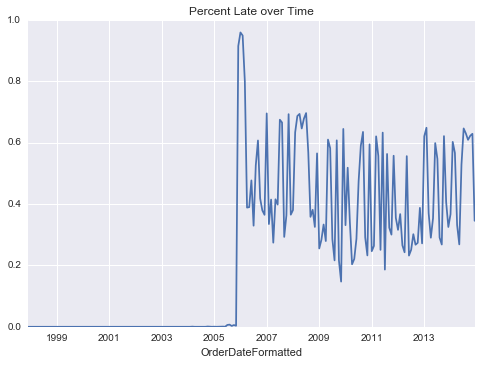

In [17]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [18]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [19]:
USMTO_WHOLE[USMTO_WHOLE.DaysLate >= 90]

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,IP,OrderDateFormatted,ChangedDateFormatted,SubmitDateFormatted,OrderDateEOM,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
805,d67c978f-0a9d-482f-870d-bea9826a7c47,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,235100.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:51:08 AM,...,102.4621,2014-01-01,2014-02-11 11:51:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
806,cb9feb62-7586-4f84-8195-6afac2f6c9da,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,147800.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:52 AM,...,102.4621,2014-01-01,2014-02-11 11:52:52,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
807,019f1f20-5135-48cd-8776-62f5a15672f8,100048,176,28273,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,28273,1,1228735.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:48:08 AM,...,102.4621,2014-01-01,2014-02-11 11:48:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
808,031861e8-bde0-4849-9dab-72bffb75fa6f,100048,209,37830,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,37830,1,138391.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:06 AM,...,102.4621,2014-01-01,2014-02-11 11:52:06,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
809,a9999f82-b3af-48e1-8e1a-afaa48601732,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,147800.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:29 AM,...,102.4621,2014-01-01,2014-02-11 11:52:29,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
810,352f8576-94be-4a2f-a042-a862769d47f8,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30512,1,141000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:53:45 AM,...,102.4621,2014-01-01,2014-02-11 11:53:45,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
811,d5bcf631-309c-4082-aafa-8746fbf5d83e,100048,175,29305,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,29301,1,165000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:47:08 AM,...,102.4621,2014-01-01,2014-02-11 11:47:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
812,e9977ea3-faed-4942-8e1b-4a423cb38eb0,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30212,1,141000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:53:19 AM,...,102.4621,2014-01-01,2014-02-11 11:53:19,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
813,d488a167-3423-4539-acf6-f59fac1c7522,100048,176,28273,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,28273,1,475000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:48:37 AM,...,102.4621,2014-01-01,2014-11-06 09:46:18,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
814,376d4588-fed6-4826-aa07-f7bbf0c39c7f,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30512,1,159000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:54:07 AM,...,102.4621,2014-01-01,2014-02-11 11:54:07,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1


In [20]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


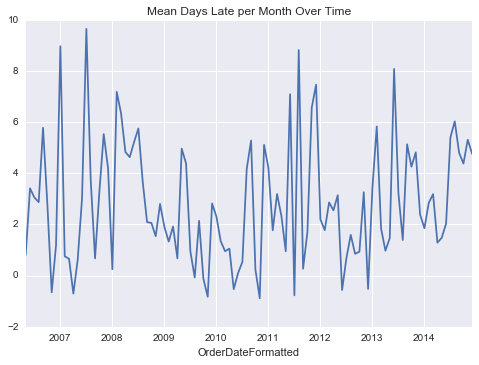

In [21]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [22]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


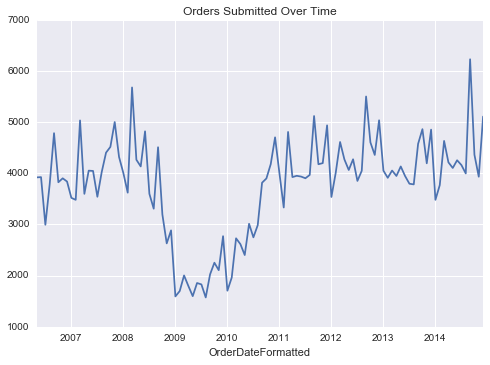

In [23]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

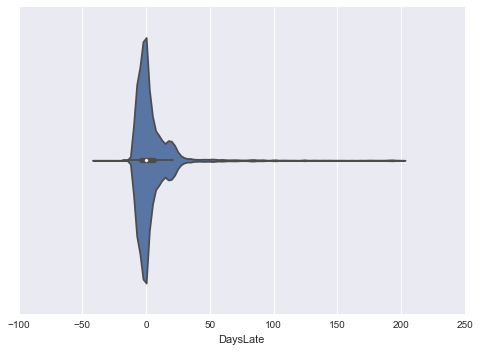

In [24]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [25]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,1.846154e+04,240000.00
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,1.000000e+05,200000.00
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,1.314387e+05,920071.00
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,1.539455e+05,307891.00
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,5.797109e+04,637682.00
5,100005,2006-08-01,15.0,1,1,1,0,1303.819946,102.8357,1,6.599400e+04,65994.00
6,100005,2006-10-01,3.0,1,0,0,0,1377.939941,102.6297,1,1.063480e+05,106348.00
7,100005,2006-11-01,-3.0,0,0,0,0,1400.630005,102.5390,15,1.291431e+05,1937146.00
8,100005,2006-12-01,-7.0,0,0,0,0,1418.300049,103.6229,1,6.636000e+04,66360.00
9,100005,2007-01-01,-9.0,0,0,0,0,1438.239990,103.1171,4,1.997450e+04,79898.01


In [26]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]


In [27]:
#temporary fill in for adding in last three months late/sales until python script is written

AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/AAID By Month')
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/AAID By Month Edited.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [28]:
AAID_BY_MONTH_NO_BACKFILL

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,Units,TotalSaleAvg,TotalSale,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP
0,100005,5/1/2006,-5,0,0,0,0,1270.089966,7,1.314387e+05,920071.00,-5.000000,9.200710e+05,0.000000,0.000000e+00,0.0,102.1531
1,100005,6/1/2006,1,1,0,0,0,1270.199951,2,1.539455e+05,307891.00,-1.000000,5.119510e+05,-5.000000,3.078910e+05,-5.0,102.5220
2,100005,7/1/2006,-8,0,0,0,0,1276.660034,11,5.797109e+04,637682.00,-5.000000,5.837973e+05,-2.000000,4.727865e+05,1.0,102.5057
3,100005,8/1/2006,15,1,1,1,0,1303.819946,1,6.599400e+04,65994.00,5.666667,3.076355e+05,-4.000000,6.218813e+05,-8.0,102.8357
4,100005,10/1/2006,3,1,0,0,0,1377.939941,1,1.063480e+05,106348.00,4.290323,2.037452e+05,2.666667,3.371890e+05,15.0,102.6297
5,100005,11/1/2006,-3,0,0,0,0,1400.630005,15,1.291431e+05,1937146.00,0.587302,1.084203e+06,3.333333,2.700080e+05,3.0,102.5390
6,100005,12/1/2006,-7,0,0,0,0,1418.300049,1,6.636000e+04,66360.00,-3.236220,5.712741e+05,5.000000,7.031627e+05,-3.0,103.6229
7,100005,1/1/2007,-9,0,0,0,0,1438.239990,4,1.997450e+04,79898.01,-6.129412,3.246226e+05,-2.333333,7.032847e+05,-7.0,103.1171
8,100005,2/1/2007,-5,0,0,0,0,1406.819946,6,8.552567e+04,513154.00,-5.563601,4.190728e+05,-6.333333,6.944680e+05,-9.0,104.1720
9,100005,3/1/2007,2,1,0,0,0,1420.859985,2,1.575025e+05,315005.00,-1.778104,3.669880e+05,-7.000000,2.198040e+05,-5.0,104.3501


In [29]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [30]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

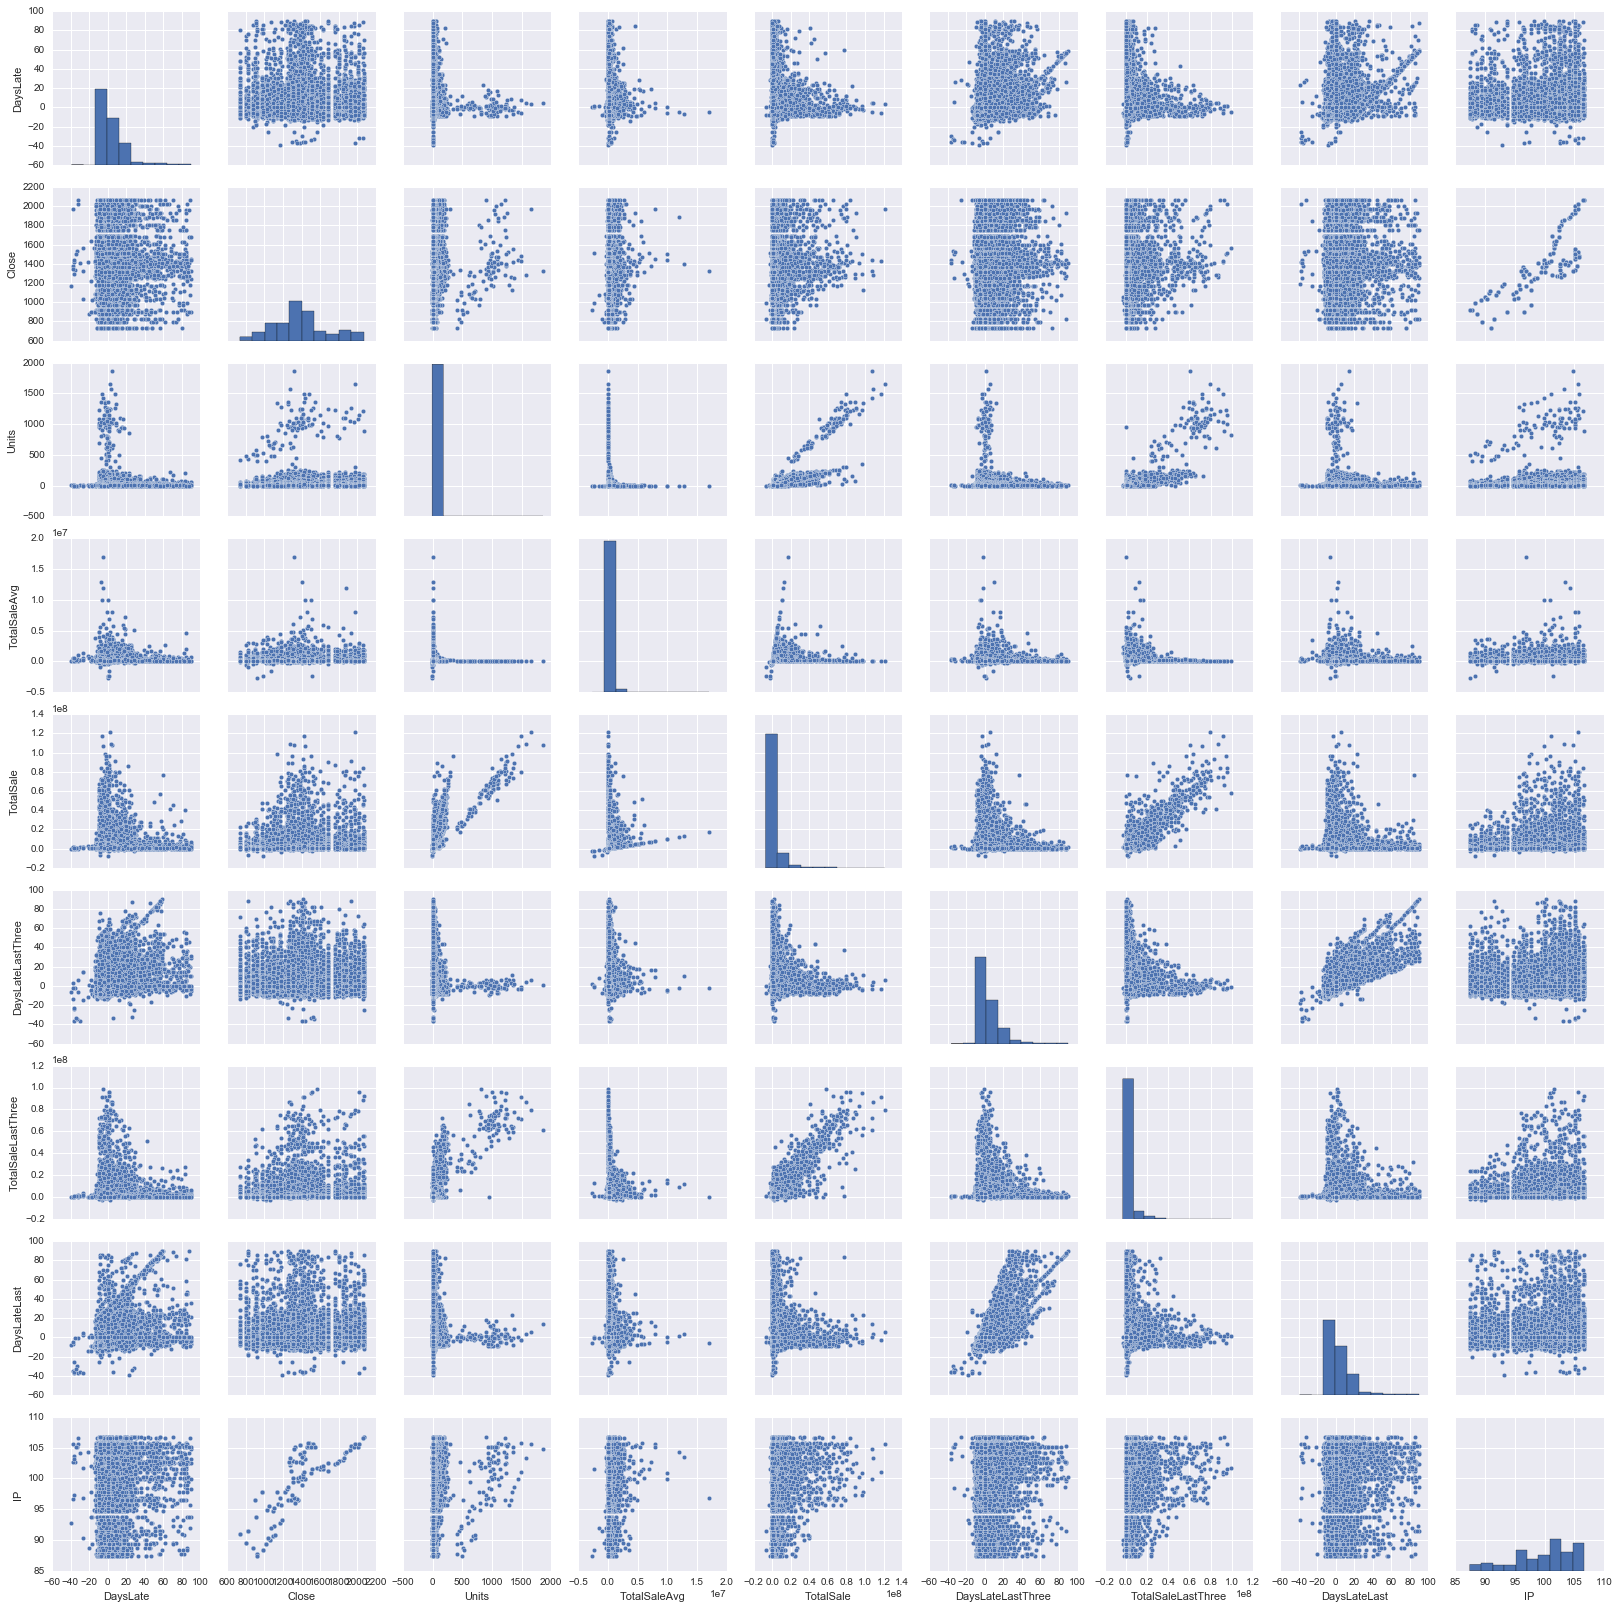

In [31]:
#scatter matrix identifying key features - target excluded

PAIRPLOT = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT = PAIRPLOT.drop('AAID', axis = 1)
PAIRPLOT = PAIRPLOT.drop('OrderDateFormatted', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailOne', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailTwo', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsCall', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsBackfill', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_Late', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_SalesTrend', axis = 1)

sns.pairplot(PAIRPLOT)

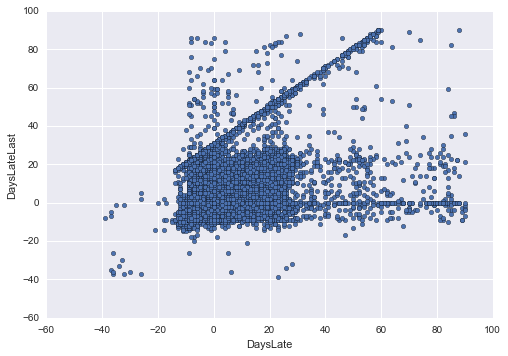

In [32]:
#DaysLate Last vs Days Late (suspicious line)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

In [33]:
#prep for correlation matrix - target included

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)


corr2 = PAIRPLOT2.corr(method = 'pearson')

In [34]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Units', 'TotalSaleAvg', 'TotalSale',
       'Three_MMA_Late', 'Three_MMA_SalesTrend', 'DaysLateLastThree',
       'TotalSaleLastThree', 'DaysLateLast', 'IP'],
      dtype='object')

In [35]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [36]:
#Correlations between Attributes

corr = PAIRPLOT.corr(method = 'pearson')

In [37]:
#Skew of Attributes

PAIRPLOT.skew()

DaysLate               2.466051
Close                  0.369165
Units                 11.854637
TotalSaleAvg          12.365677
TotalSale              6.010543
DaysLateLastThree      2.282692
TotalSaleLastThree     5.921180
DaysLateLast           2.516090
IP                    -0.724223
dtype: float64

In [38]:
PAIRPLOT2.corr()

,IsCall,Close,Units,TotalSaleAvg,TotalSale,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP
IsCall,1.000000,0.077764,-0.026634,0.027854,-0.001683,0.757631,-0.003002,0.468473,-0.008318,0.449449,0.122950
Close,0.077764,1.000000,0.036651,0.028971,0.065513,0.072659,0.064332,0.055856,0.063488,0.060961,0.789642
Units,-0.026634,0.036651,1.000000,-0.056081,0.781912,-0.018572,0.793379,-0.020500,0.767313,-0.013741,0.047023
TotalSaleAvg,0.027854,0.028971,-0.056081,1.000000,0.142124,0.029816,0.116667,0.029674,0.084620,0.025975,0.035300
TotalSale,-0.001683,0.065513,0.781912,0.142124,1.000000,0.003386,0.972172,-0.005216,0.897373,0.002898,0.079643
Three_MMA_Late,0.757631,0.072659,-0.018572,0.029816,0.003386,1.000000,0.002579,0.773360,-0.004209,0.747065,0.124476
Three_MMA_SalesTrend,-0.003002,0.064332,0.793379,0.116667,0.972172,0.002579,1.000000,-0.003181,0.965752,0.003329,0.083472
DaysLateLastThree,0.468473,0.055856,-0.020500,0.029674,-0.005216,0.773360,-0.003181,1.000000,0.000280,0.805167,0.100720
TotalSaleLastThree,-0.008318,0.063488,0.767313,0.084620,0.897373,-0.004209,0.965752,0.000280,1.000000,0.002877,0.080767
DaysLateLast,0.449449,0.060961,-0.013741,0.025975,0.002898,0.747065,0.003329,0.805167,0.002877,1.000000,0.095675


In [39]:
corr2

,IsCall,Close,Units,TotalSaleAvg,TotalSale,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP
IsCall,1.000000,0.077764,-0.026634,0.027854,-0.001683,0.757631,-0.003002,0.468473,-0.008318,0.449449,0.122950
Close,0.077764,1.000000,0.036651,0.028971,0.065513,0.072659,0.064332,0.055856,0.063488,0.060961,0.789642
Units,-0.026634,0.036651,1.000000,-0.056081,0.781912,-0.018572,0.793379,-0.020500,0.767313,-0.013741,0.047023
TotalSaleAvg,0.027854,0.028971,-0.056081,1.000000,0.142124,0.029816,0.116667,0.029674,0.084620,0.025975,0.035300
TotalSale,-0.001683,0.065513,0.781912,0.142124,1.000000,0.003386,0.972172,-0.005216,0.897373,0.002898,0.079643
Three_MMA_Late,0.757631,0.072659,-0.018572,0.029816,0.003386,1.000000,0.002579,0.773360,-0.004209,0.747065,0.124476
Three_MMA_SalesTrend,-0.003002,0.064332,0.793379,0.116667,0.972172,0.002579,1.000000,-0.003181,0.965752,0.003329,0.083472
DaysLateLastThree,0.468473,0.055856,-0.020500,0.029674,-0.005216,0.773360,-0.003181,1.000000,0.000280,0.805167,0.100720
TotalSaleLastThree,-0.008318,0.063488,0.767313,0.084620,0.897373,-0.004209,0.965752,0.000280,1.000000,0.002877,0.080767
DaysLateLast,0.449449,0.060961,-0.013741,0.025975,0.002898,0.747065,0.003329,0.805167,0.002877,1.000000,0.095675


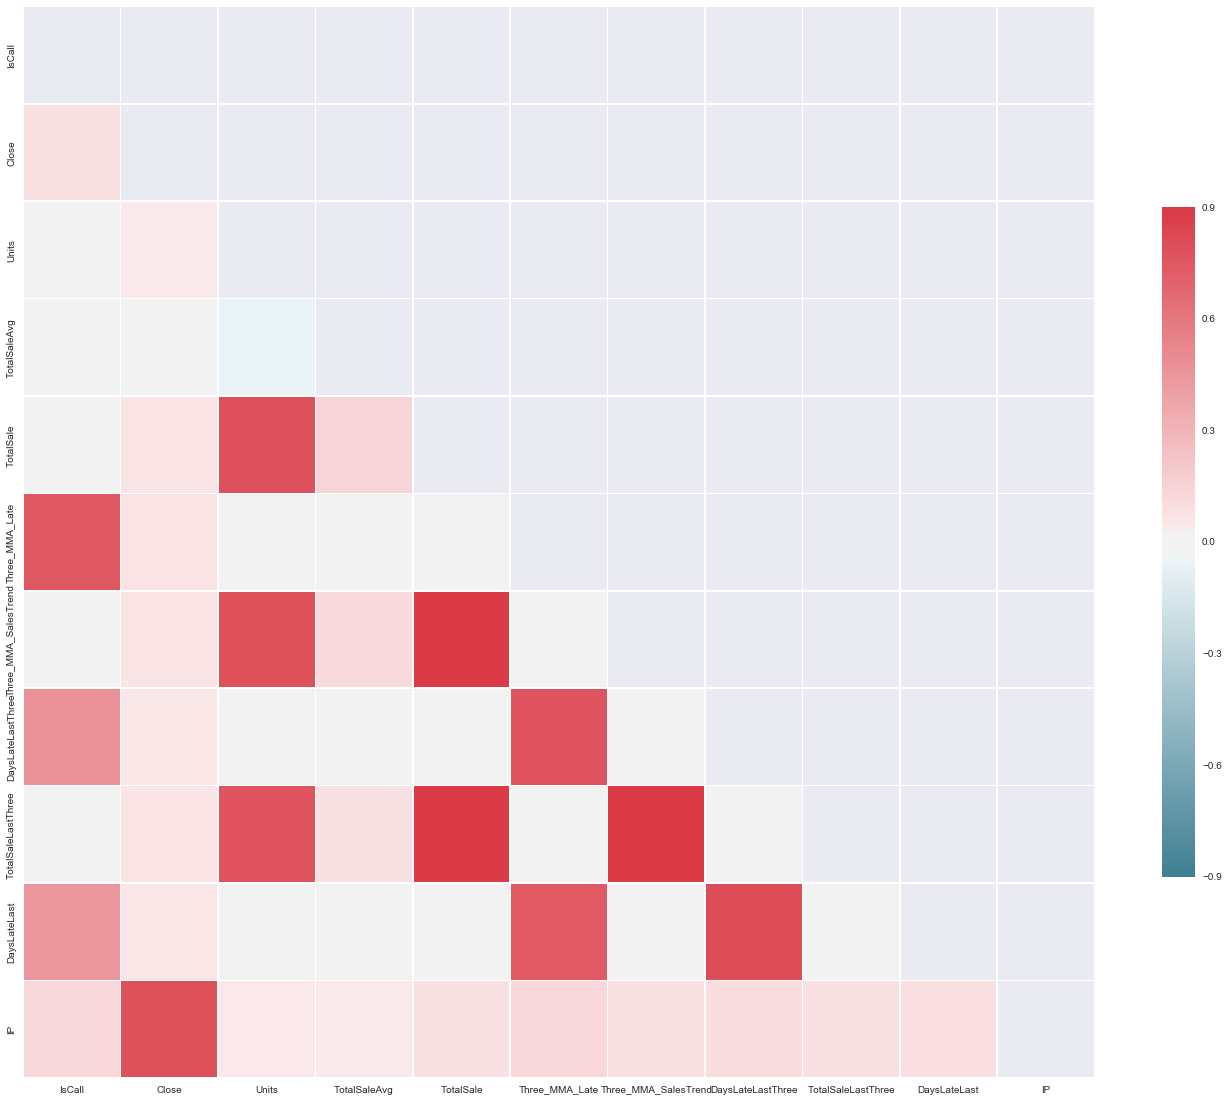

In [40]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24,24))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.9,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


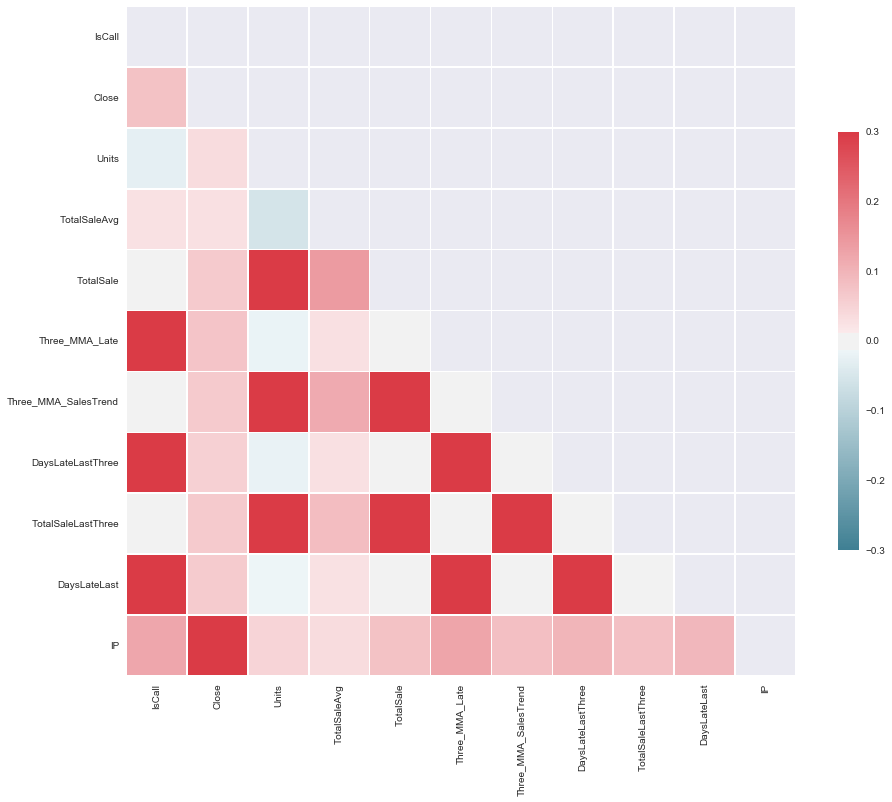

In [41]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [42]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:11]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

#rescaledX2 = rescaledX.reshape((-1,11))

#rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'TotalSaleAvg':rescaledX[:,2],'TotalSale':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6]})


In [44]:
#relationship between last month's days late and this month's call

#rescaledX3.plot.scatter('DaysLateLast','IsCall')

In [45]:
#columns which correspond to feature selection output

PAIRPLOT2.columns

Index(['IsCall', 'Close', 'Units', 'TotalSaleAvg', 'TotalSale',
       'Three_MMA_Late', 'Three_MMA_SalesTrend', 'DaysLateLastThree',
       'TotalSaleLastThree', 'DaysLateLast', 'IP'],
      dtype='object')

In [46]:
# Feature Importance with Extra Trees Classifier - Three_MMA_Late, Three_MMA_SalesTrend, DaysLateLast are selected (threshold 0.1)

from sklearn.ensemble import ExtraTreesClassifier

# load data

array = PAIRPLOT2.values
X = array[:,1:11]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.02227123  0.02320285  0.02517803  0.02382591  0.60003571  0.02314053
  0.12990709  0.0244907   0.09765185  0.03029609]


In [47]:
# Feature Extraction with RFE - IP, DaysLateLast, DaysLateLastThree, Three_MMA_Late are selected

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load data

array = PAIRPLOT2.values
X = array[:,1:11]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [False False False False  True False  True False  True  True]
Feature Ranking:  [2 3 4 7 1 6 1 5 1 1]


In [48]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:11]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [ 0.96211391  0.03473492  0.00217001  0.00098115]
[[  1.45914098e-06   5.05593119e-06   3.82621349e-03   5.97378991e-01
    6.18777565e-10   5.75233576e-01  -2.60559128e-09   5.58775477e-01
    3.29838645e-09   3.07694134e-08]
 [  4.19294780e-07   6.70539145e-07   2.19937544e-02   6.83439502e-01
    7.40490869e-08  -1.09884449e-03  -5.72621156e-08  -7.29674937e-01
    5.56220860e-10  -7.01883914e-09]
 [  8.61614067e-06   9.92209909e-07   1.63282796e-02   4.18885176e-01
   -4.76520219e-07  -8.17912022e-01   9.78421745e-08   3.94066645e-01
   -7.58901274e-08  -9.96459486e-08]
 [ -1.43505995e-05   3.08702320e-05  -9.99617437e-01   2.41660193e-02
   -7.48681100e-07  -1.11825756e-02  -9.08725842e-07  -7.47872780e-03
   -8.71321140e-07  -3.10972494e-07]]


In [49]:
#we end up using all features

In [50]:
#train/test algorithm using all 10 features

# Evaluate using a train and a test set
from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:11]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Accuracy: ", result*100.0)

Accuracy:  76.3694748772


In [51]:
# Evaluate using Cross Validation using all 10 features

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:11]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LogisticRegression()
results = cross_validation.cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: ", results.mean()*100.0, "      Std Dev: ", results.std()*100.0)

Accuracy:  76.77680798       Std Dev:  5.37746665191


In [53]:
PAIRPLOT2

,IsCall,Close,Units,TotalSaleAvg,TotalSale,Three_MMA_Late,Three_MMA_SalesTrend,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP
0,0,1270.089966,7,1.314387e+05,920071.00,-5.000000,9.200710e+05,0.000000,0.000000e+00,0.0,102.1531
1,0,1270.199951,2,1.539455e+05,307891.00,-1.000000,5.119510e+05,-5.000000,3.078910e+05,-5.0,102.5220
2,0,1276.660034,11,5.797109e+04,637682.00,-5.000000,5.837973e+05,-2.000000,4.727865e+05,1.0,102.5057
3,1,1303.819946,1,6.599400e+04,65994.00,5.666667,3.076355e+05,-4.000000,6.218813e+05,-8.0,102.8357
4,0,1377.939941,1,1.063480e+05,106348.00,4.290323,2.037452e+05,2.666667,3.371890e+05,15.0,102.6297
5,0,1400.630005,15,1.291431e+05,1937146.00,0.587302,1.084203e+06,3.333333,2.700080e+05,3.0,102.5390
6,0,1418.300049,1,6.636000e+04,66360.00,-3.236220,5.712741e+05,5.000000,7.031627e+05,-3.0,103.6229
7,0,1438.239990,4,1.997450e+04,79898.01,-6.129412,3.246226e+05,-2.333333,7.032847e+05,-7.0,103.1171
8,0,1406.819946,6,8.552567e+04,513154.00,-5.563601,4.190728e+05,-6.333333,6.944680e+05,-9.0,104.1720
9,0,1420.859985,2,1.575025e+05,315005.00,-1.778104,3.669880e+05,-7.000000,2.198040e+05,-5.0,104.3501


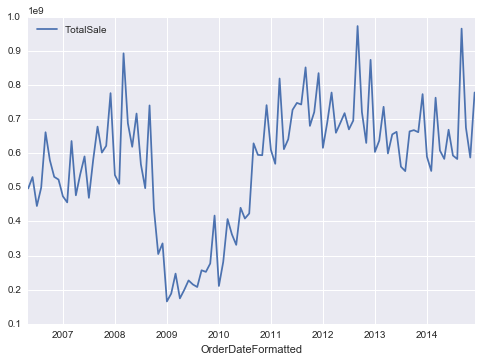

In [54]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

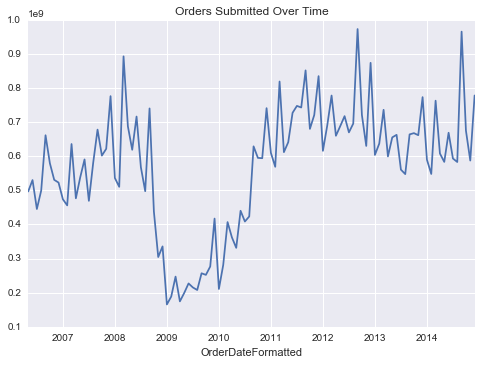

In [55]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

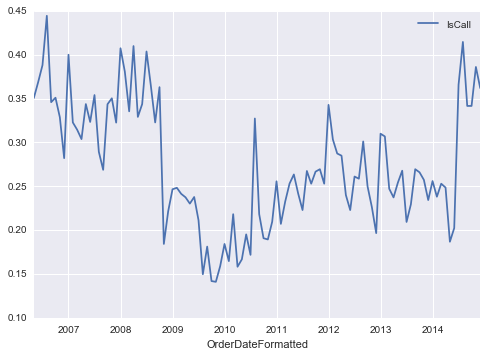

In [56]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

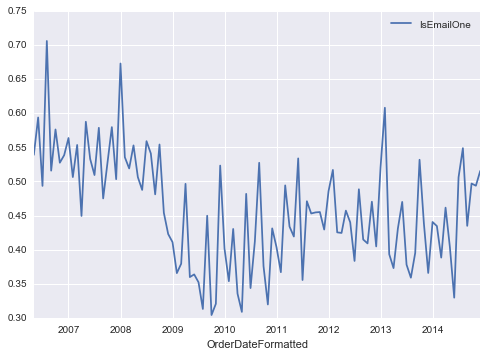

In [57]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

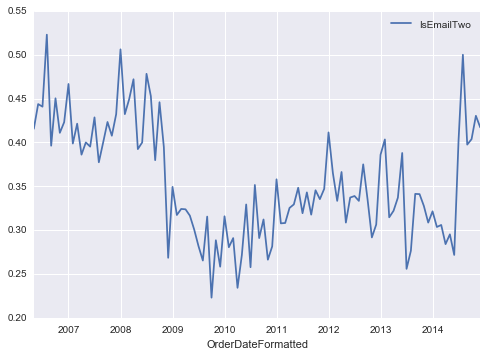

In [58]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

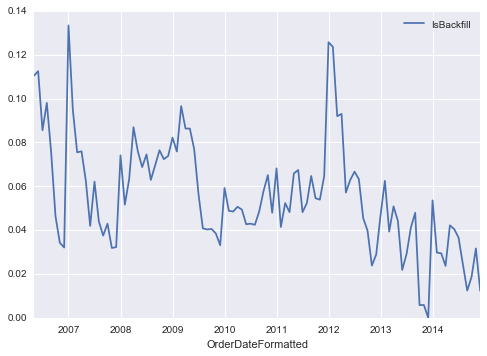

In [59]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [60]:
#APPENDIX AS FOLLOWS: (works in progress)

In [61]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



SyntaxError: invalid syntax (<ipython-input-61-8bd383b2e483>, line 6)

In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE